# Hydrological Flood Detection – **v4** (Per‑Station XGBoost)

Trains one XGBoost model per station using rainfall windows, discharge lags, rate-of-change, and 7‑day antecedent precipitation (API7). Floods are labelled as discharge above the 92‑percentile for each station.

In [1]:
# Auto-install required packages if missing
import importlib, subprocess, sys, warnings
for pkg in ['xgboost']:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
warnings.filterwarnings('ignore')


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, average_precision_score
import joblib, datetime, os

# CONFIG
PROJECT_ROOT = Path.cwd() if (Path.cwd()/'data').exists() else Path.cwd().parent
DATA_RAW = PROJECT_ROOT/'data'/'raw'
STATIONS = ['D08A071','D08A084','D08A115']
ROLL_WINDOWS = [3,6,12]
LAG_HRS = range(1,13)
PERCENTILE = 0.82
TEST_FRAC = 0.2
API_WINDOW = 24*7
RANDOM_SEED = 42


In [3]:
def find_csv(code):
    p = DATA_RAW / f'station_{code}'
    files = list(p.glob('*.csv'))
    assert len(files)==1, f'{code}: expected 1 csv'
    return files[0]

def load_station(code):
    df = pd.read_csv(find_csv(code))
    df['datetime'] = pd.to_datetime(df['saatlik'])
    df = (df.rename(columns={'yagis_toplam':'rain_mm','qdeger':'discharge_cms'})
            .set_index('datetime').sort_index()
            .resample('h')
            .agg({'rain_mm':'sum','discharge_cms':'mean'}))
    df['station'] = code
    return df


In [4]:
# Load all stations
frames = [load_station(c) for c in STATIONS]
full   = pd.concat(frames, keys=STATIONS, names=['station','datetime'])
print('Shape:', full.shape)


Shape: (251649, 3)


In [5]:
def build_features(df):
    st = df.copy()
    for w in ROLL_WINDOWS:
        st[f'rain_sum_{w}h'] = st['rain_mm'].rolling(w, min_periods=1).sum()
    for l in LAG_HRS:
        st[f'dis_lag_{l}h'] = st['discharge_cms'].shift(l)
    st['dis_rate_1h'] = st['discharge_cms'].diff(1)
    st['dis_rate_3h'] = st['discharge_cms'].diff(3)
    st['API7'] = st['rain_mm'].rolling(API_WINDOW, min_periods=1).sum()
    st.dropna(inplace=True)
    print('After FE:', )
    thr = st['discharge_cms'].quantile(PERCENTILE)
    st['flood'] = (st['discharge_cms'] > thr).astype(int)
    return st


In [6]:
# 
# ║  Build combined feature set (all three stations concatenated)       ║
frames = []
for code in STATIONS:
    df = build_features(load_station(code))   # uses the helper we defined earlier
    df['station'] = code                      # keep station tag for later if needed
    frames.append(df)

combined_df = pd.concat(frames)
feature_cols = [c for c in combined_df.columns
                if c.startswith(('rain_sum', 'dis_lag', 'dis_rate', 'API'))]

X_comb = combined_df[feature_cols]
y_comb = combined_df['flood']

print("Combined dataset shape:", combined_df.shape)
print("Flood hours:", y_comb.sum(), "out of", len(y_comb),
      f"({y_comb.mean():.2%})")

After FE:
After FE:
After FE:
Combined dataset shape: (79459, 22)
Flood hours: 11479 out of 79459 (14.45%)


In [7]:
feature_cols_global = None
reports = []
models = {}
os.makedirs(PROJECT_ROOT/'models/per_station', exist_ok=True)

for code in STATIONS:
    df_raw = load_station(code)
    df = build_features(df_raw)
    feature_cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]
    feature_cols_global = feature_cols
    split = int(len(df)*(1-TEST_FRAC))
    X_tr, X_te = df.iloc[:split][feature_cols], df.iloc[split:][feature_cols]
    y_tr, y_te = df.iloc[:split]['flood'], df.iloc[split:]['flood']
    neg, pos = np.bincount(y_tr)
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        learning_rate=0.05,
        n_estimators=800,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_SEED,
        scale_pos_weight=neg/pos,
        n_jobs=-1,
    )
    model.fit(X_tr, y_tr)
    models[code] = model
    joblib.dump(model, PROJECT_ROOT/f'models/per_station/xgb_{code}_{datetime.date.today()}.pkl')
    y_prob = model.predict_proba(X_te)[:,1]
    y_pred = (y_prob>0.5).astype(int)
    rpt = classification_report(y_te, y_pred, output_dict=True)
    pr_auc = average_precision_score(y_te, y_prob)
    reports.append({
        'station':code,
        'precision':round(rpt['1']['precision'],3),
        'recall':round(rpt['1']['recall'],3),
        'f1':round(rpt['1']['f1-score'],3),
        'PR-AUC':round(pr_auc,3),
        'test_flood_hours':int(y_te.sum())
    })

summary = pd.DataFrame(reports).set_index('station')
summary


After FE:
After FE:
After FE:


,precision,recall,f1,PR-AUC,test_flood_hours
station,,,,,
D08A071,0.999,1.0,1.000,1.000,1883
D08A084,1.000,1.0,1.000,1.000,524
D08A115,0.972,1.0,0.986,0.998,106


In [8]:
summary_rows = []

for code in STATIONS:
    # If you cached frames in station_frames dict, use that to avoid re-reading:
    # df_fe = station_frames[code]
    df_raw = load_station(code)
    df_fe  = build_features(df_raw.copy())

    split = int(len(df_fe)*(1-TEST_FRAC))
    train_sz = split
    test_sz  = len(df_fe) - split

    flood_dist = df_fe['flood'].value_counts().to_dict()

    summary_rows.append({
        'station': code,
        'raw_shape': df_raw.shape,
        'after_FE_shape': df_fe.shape,
        'flood_distribution': flood_dist,
        'train_size': train_sz,
        'test_size': test_sz
    })

pd.DataFrame(summary_rows).set_index('station')

After FE:
After FE:
After FE:


,raw_shape,after_FE_shape,flood_distribution,train_size,test_size
station,,,,,
D08A071,"(96432, 3)","(25551, 22)","{0: 20964, 1: 4587}",20440,5111
D08A084,"(77587, 3)","(31967, 22)","{0: 28997, 1: 2970}",25573,6394
D08A115,"(77630, 3)","(21941, 22)","{0: 18019, 1: 3922}",17552,4389


After FE:


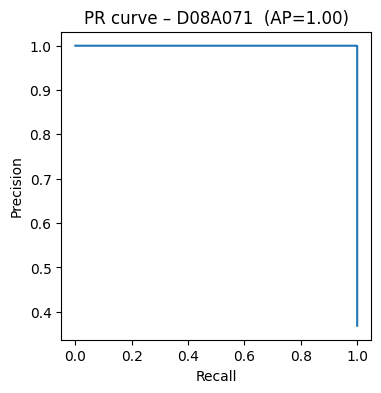

After FE:


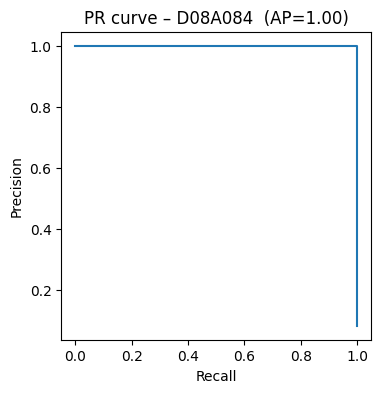

After FE:


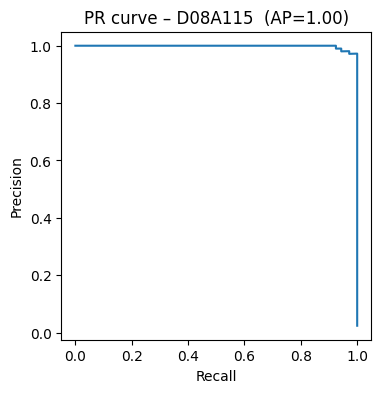

Threshold sweep (first rows):


,station,thr,precision,recall
0,D08A071,0.0000,0.368,1.0
1,D08A071,0.0000,0.369,1.0
2,D08A071,0.0000,0.369,1.0
3,D08A071,0.0000,0.369,1.0
4,D08A071,0.0000,0.369,1.0
5,D08A071,0.0000,0.369,1.0
6,D08A071,0.0000,0.369,1.0
7,D08A071,0.0000,0.483,1.0
8,D08A071,0.0000,0.483,1.0
9,D08A071,0.0000,0.484,1.0


In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

sweep_rows = []

for code, model in models.items():
    # --- recreate feature frame for this station ---
    df = build_features(load_station(code))

    # same train/test split as before
    split = int(len(df)*(1-TEST_FRAC))
    X_te = df.iloc[split:][feature_cols_global]
    y_te = df.iloc[split:]['flood']
    y_prob = model.predict_proba(X_te)[:,1]

    # PR metrics
    prec, rec, thr = precision_recall_curve(y_te, y_prob)
    ap   = average_precision_score(y_te, y_prob)

    # store first 15 rows of sweep
    for p,r,t in zip(prec[:15], rec[:15], thr[:15]):
        sweep_rows.append({'station':code,
                           'thr': round(float(t),4),
                           'precision': round(p,3),
                           'recall': round(r,3)})

    # PR curve
    plt.figure(figsize=(4,4))
    plt.plot(rec, prec)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title(f'PR curve – {code}  (AP={ap:.2f})')
    plt.show()

sweep_df = pd.DataFrame(sweep_rows)
print("Threshold sweep (first rows):")
sweep_df.head(20)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_true_all, y_pred_all = [], []

for code, model in models.items():
    df = build_features(load_station(code))
    split = int(len(df)*(1-TEST_FRAC))
    X_te = df.iloc[split:][feature_cols_global]
    y_te = df.iloc[split:]['flood']
    y_prob = model.predict_proba(X_te)[:,1]
    y_pred = (y_prob > 0.005).astype(int)

    y_true_all.append(y_te)
    y_pred_all.append(pd.Series(y_pred, index=y_te.index))

y_true_all = pd.concat(y_true_all)
y_pred_all = pd.concat(y_pred_all)

print("OVERALL accuracy :", round(accuracy_score(y_true_all, y_pred_all),3))
print("OVERALL precision:", round(precision_score(y_true_all, y_pred_all),3))
print("OVERALL recall   :", round(recall_score(y_true_all, y_pred_all),3))
print("OVERALL confusion matrix:\n", confusion_matrix(y_true_all, y_pred_all))

After FE:
After FE:
After FE:
OVERALL accuracy : 0.998
OVERALL precision: 0.988
OVERALL recall   : 1.0
OVERALL confusion matrix:
 [[13350    31]
 [    0  2513]]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score

print("\n### Random 70/30 split (stratified) – per station\n")
rand_rows = []
for code in STATIONS:
    df = build_features(load_station(code))
    feat_cols = [c for c in df.columns if c.startswith(('rain_sum','dis_lag','dis_rate','API'))]

    X = df[feat_cols]
    y = df['flood']

    # stratified random split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y)

    neg, pos = np.bincount(y_tr)
    clf = XGBClassifier(
        learning_rate=0.05, n_estimators=800, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        scale_pos_weight=neg/pos, eval_metric='aucpr')
    clf.fit(X_tr, y_tr)

    y_prob = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_prob > 0.5).astype(int)
    rpt = classification_report(y_te, y_pred, output_dict=True)

    rand_rows.append({
        'station': code,
        'precision': round(rpt['1']['precision'], 3),
        'recall':    round(rpt['1']['recall'],    3),
        'f1':        round(rpt['1']['f1-score'],  3),
        'PR-AUC':    round(average_precision_score(y_te, y_prob), 3),
        'test_floods': int(y_te.sum())
    })

pd.DataFrame(rand_rows).set_index('station')


### Random 70/30 split (stratified) – per station

After FE:
After FE:
After FE:


,precision,recall,f1,PR-AUC,test_floods
station,,,,,
D08A071,1.000,0.999,0.999,1.0,1376
D08A084,0.998,1.000,0.999,1.0,891
D08A115,0.999,0.999,0.999,1.0,1177


In [12]:
from sklearn.model_selection import train_test_split

SEED = 42  # ensure defined

X_tr_r, X_te_r, y_tr_r, y_te_r = train_test_split(
    X_comb, y_comb, test_size=0.30, random_state=SEED, stratify=y_comb)

neg, pos = np.bincount(y_tr_r)
clf_r = XGBClassifier(
    learning_rate=0.05, n_estimators=800, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=SEED,
    scale_pos_weight = neg / pos,
    eval_metric='aucpr'
)
clf_r.fit(X_tr_r, y_tr_r)

y_prob_r = clf_r.predict_proba(X_te_r)[:, 1]
y_pred_r = (y_prob_r > 0.50).astype(int)

print("=== Random 70/30 split ===")
print(classification_report(y_te_r, y_pred_r))
print("PR-AUC:", average_precision_score(y_te_r, y_prob_r))

=== Random 70/30 split ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20394
           1       0.97      1.00      0.98      3444

    accuracy                           1.00     23838
   macro avg       0.99      1.00      0.99     23838
weighted avg       1.00      1.00      1.00     23838

PR-AUC: 0.9995307174608618
